## Modifying Notebook display

In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    .container#notebook-container    { width: 95%;}
    div#menubar-container     { width: 95%; }
    div#maintoolbar-container { width: 95%; }
</style>
<script>
    document.getElementById("notebook-container").style.margin = "auto";
</script>
"""))

## For running the notebook as Google Colab Instance

``
#mounting the google drive for accessing other necessary files
from google.colab import drive
drive.mount('/content/gdrive')
``

``
#Checking the available files in the "Colab Notebooks" folder of the google drive
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/Handwritten\ Digit\ Recognition
``

``
import sys
``

``
#changing the current working directory to "Colab Notebooks" folder in the google drive
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Handwritten Digit Recognition')
``

## For running the notebook as Kaggle Kernel

change directory to the dataset where our custom scripts are uploaded

> ``os.chdir("/kaggle/input/handwritten-digit-recognition")``

***handwritten-digit-recognition*** is simply a folder name. It can vary based on the dataset you create in kaggle while uploading the python scripts.


load custom module or files or dataset

> ``from  dataset import load_dataset, train_dev_split, prep_dataset`` <br>
> ```from dataset import visualize_data_distribution, visualize_dataset```


reset our working directory

> ```os.chdir("/kaggle/working/")```

**NOTE:** The ***input directory*** is Read-Only. So, we must switch back to the ***working directory*** for performing any other operation that requires write access. Make sure this note book runs as a part of the dataset you create as said above because all the custom modules are uploaded there. 


## Importing Dependencies

In [2]:
import time    #for calculating time
import os
#core packages
import numpy as np
import matplotlib.pyplot as plt

# os.chdir("/kaggle/input/handwritten-digit-recognition")

#custom module
from  dataset import load_dataset, train_dev_split, prep_dataset
from dataset import visualize_data_distribution, visualize_dataset

from ModelUtils import relu, relu_grad, softmax
from ModelUtils import rand_mini_batches, convert_time
from ModelUtils import confusion_matrix, plot_confusion_matrix, model_metrics, metric_summary
from ModelUtils import visualize_training_results, visualize_prediction, visualize_mislabelled_images
from ModelUtils import save_model, load_model

from dataAugmentation import data_generator

from ffnn import *

# # reset our working directory
# os.chdir("/kaggle/working/")

np.random.seed(1)
%matplotlib inline

## Dataset Preparation

### Loading Dataset

In [3]:
dataset_size_in_per = 50

train_x_orig, train_y_orig, test_x_orig, test_y_orig = load_dataset(dataset = "mnist", size_in_per = dataset_size_in_per)

print("Sample Size : %d%%\n"%(dataset_size_in_per))
print("Data\t\t\t","Datatype\t\t","Dataset Size")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")



No destination directory exists to load the data from:
Creating 'dataset/mnist/' as a new directory...


train-images-idx3-ubyte.gz: downloading...
9.453 MB  [9.453 MB done ==========> 100%]
train-labels-idx1-ubyte.gz: downloading...
0.028 MB  [0.028 MB done ==========> 100%]
t10k-images-idx3-ubyte.gz: downloading...
1.572 MB  [1.572 MB done ==========> 100%]
t10k-labels-idx1-ubyte.gz: downloading...
0.004 MB  [0.004 MB done ==========> 100%]

Dataset download succeeded...

Decompressing the mnist dataset...
Dataset decompression succeeded...
Sample Size : 50%

Data			 Datatype		 Dataset Size
Training Set Images:	<class 'numpy.ndarray'>	 (30000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (30000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


### Train-Dev set Split

In [4]:
train_x_split, train_y_split, dev_x_split, dev_y_split = train_dev_split(train_x_orig, train_y_orig)

print("Data\t\t\t\t","Datatype\t\t","Shape")
print("========================================================================")
print("Training Set Images:\t\t" + str(type(train_x_split))+"\t",str(train_x_split.shape))
print("Training Set Labels:\t\t" + str(type(train_y_split))+"\t",str(train_y_split.shape))
print("Development Set Images:\t\t" + str(type(dev_x_split))+"\t",str(dev_x_split.shape))
print("Development Set Labels:\t\t" + str(type(dev_y_split))+"\t",str(dev_y_split.shape))
print("========================================================================")


Data				 Datatype		 Shape
Training Set Images:		<class 'numpy.ndarray'>	 (25000, 28, 28)
Training Set Labels:		<class 'numpy.ndarray'>	 (25000, 1)
Development Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Development Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)


### Visualizing Data Distribution

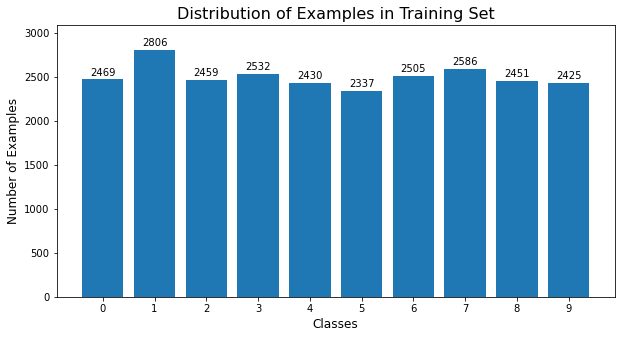

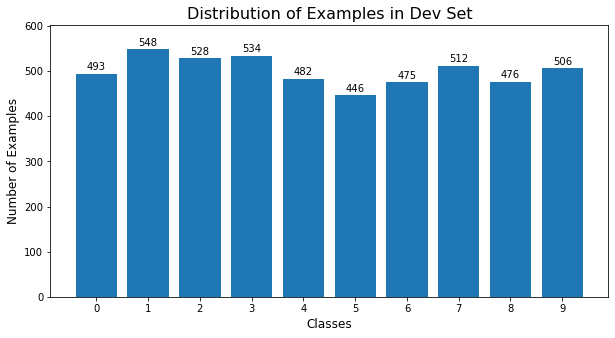

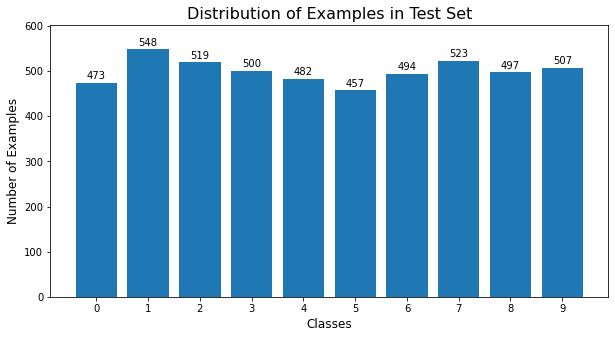

In [5]:
visualize_data_distribution(train_y_split, dataset_type = "training")
visualize_data_distribution(dev_y_split,  dataset_type = "dev")
visualize_data_distribution(test_y_orig,  dataset_type = "test")

### Visualizing Dataset

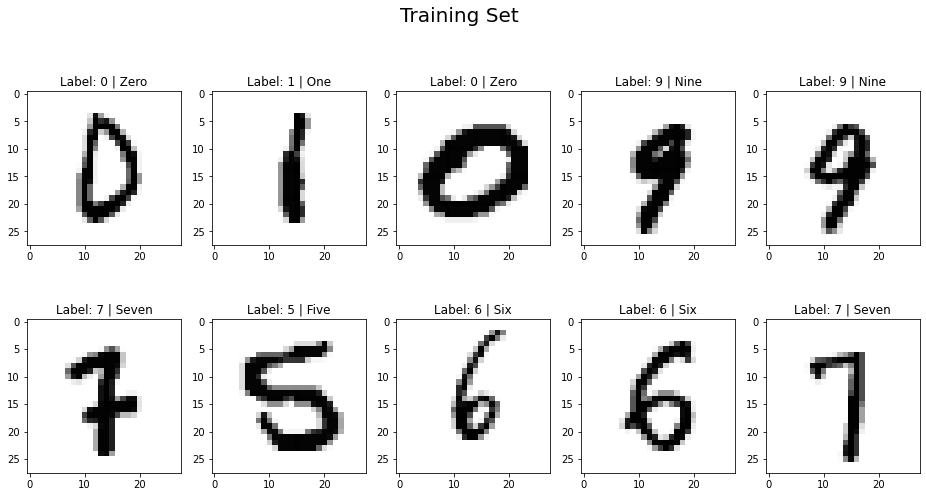

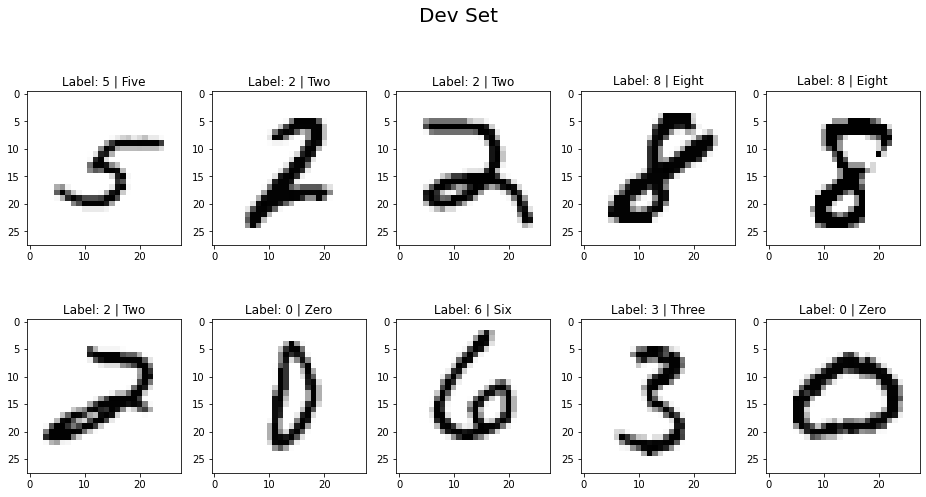

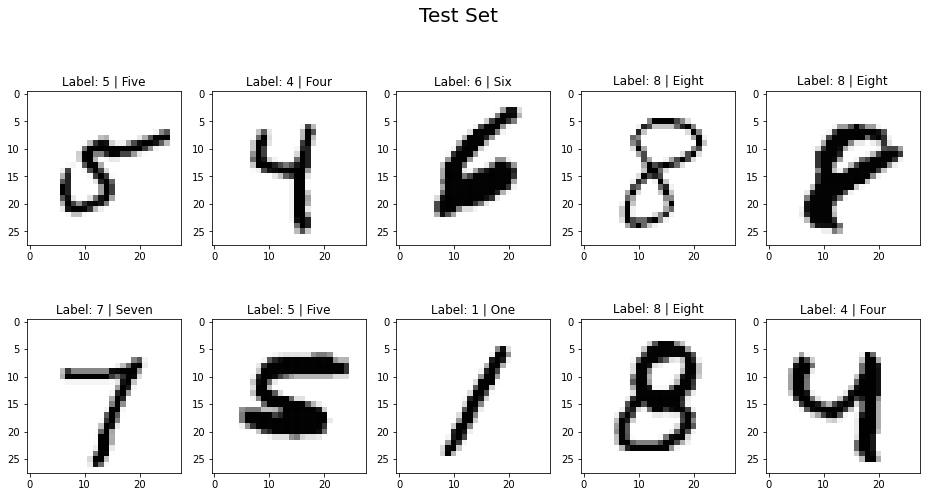

In [6]:
visualize_dataset(train_x_split, train_y_split, dataset = "mnist", dataset_type = "training")
visualize_dataset(dev_x_split, dev_y_split, dataset = "mnist", dataset_type = "dev")
visualize_dataset(test_x_orig, test_y_orig, dataset = "mnist", dataset_type="test")

### Preparing Dataset

In [7]:
train_x_norm, train_y_encoded = prep_dataset(train_x_split, train_y_split, num_class = 10)
dev_x_norm, dev_y_encoded= prep_dataset(dev_x_split, dev_y_split, num_class = 10)
test_x_norm, test_y_encoded = prep_dataset(test_x_orig, test_y_orig, num_class = 10)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_split.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_split.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_split.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_split.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")


Data			 Before Processing	 After Processing
Training Set Images:	(25000, 28, 28)		(784, 25000)
Training Set Labels:	(25000, 1)		(10, 25000)
Dev Set Images:		(5000, 28, 28)		(784, 5000)
Dev Set Labels:		(5000, 1)		(10, 5000)
Test Set Images:	(5000, 28, 28)		(784, 5000)
Test Set Labels:	(5000, 1)		(10, 5000)


### Train Model

In [10]:
# Final Model Training

def train(training_data, validation_data , layers_dim, hyperParams, initialization = "random", optimizer = 'bgd',regularizer = None, verbose = 3, patience = None):
    # unpacking the hyperparameters
    learning_rate = hyperParams['learning_rate']
    num_epoch = hyperParams['num_epoch']
    b1 = hyperParams['beta1']
    b2 = hyperParams['beta2']
    ep = hyperParams['epsilon']
    lambd = hyperParams['lambda']
    keep_probs = hyperParams['keep_probs']
    
    # unpacking the data
    X_train, Y_train = training_data
    X_dev,Y_dev = validation_data

    # setting up necessary variables for early stopping
    if patience != None and patience !=0:
        # configuring path to save the intermediate best parameters
        path = "temp/" 
        if not os.path.exists(path):
            os.makedirs(path) 
        filename = "best_param_intermediate"

        early_stop_count = 0 # count variable for counting consucative the epochs without progress
        max_val_acc = 0 # for keeping track of maximum validation accuracy
    
    #initializing the training variables
    seed = 1
    m = Y_train.shape[1]
    train_accs = []  # for keeping track of training accuracy
    val_accs = []     # for keeping track of Validation accuracy
    train_losses = []  # for keeping track of training loss
    val_losses = []     # for keeping track of Validation loss
    
    #selecting the minibatch size for each optimizer
    if optimizer == 'sgd':
        mini_batch_size = 1
    elif optimizer == 'bgd':
        mini_batch_size = m
    elif optimizer == 'mgd' or optimizer == 'adam':
        mini_batch_size = hyperParams['mini_batch_size']
    else:
        raise ValueError("Optimizer value out of scope")
        
    #initializing the model parameters
    parameters = init_parameters(layers_dim, initialization)
    
    #initializing adam parameters, used only when optimizer = 'adam'
    t = 0
    v,s = initialize_adam(parameters)
    
    train_tic = time.time() # for calculating entire training time
    print("Training The Model...")
    
    #Gradient Descent begins
    for i in range(num_epoch):
        seed += 1
        time_trained = 0 # for computing training time of each epoch
        batch_times = [] # for accumulating the training time of each batch
        accs = [] # for tracking batch training accuracy
        losses = [] # for tracking batch training loss
        
          
        if verbose > 0:
            print("\nEpoch %d/%d"%(i+1,num_epoch))
                
        #generating minimatches
        minibatches = rand_mini_batches(X_train, Y_train, mini_batch_size, seed)
        total_minibatches = len(minibatches)
        
        for ind, minibatch in enumerate(minibatches):
            batch_tic = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward Propagation
            AL, caches, dropout_masks = forward_prop(minibatch_X, parameters, keep_probs = keep_probs, regularizer = regularizer)
            
            #Computing cross entropy cost
            cross_entropy_cost = softmax_cross_entropy_cost(AL, minibatch_Y, caches, lambd = lambd, regularizer = regularizer, from_logits = True) #accumulating the batch costs
            
            #Backward Propagation
            grads = backward_prop(AL, minibatch_Y, caches, dropout_masks = dropout_masks, keep_probs = keep_probs, lambd = lambd, regularizer = regularizer)
                
            #Updating parameters
            t += 1
            parameters, v, s = update_parameters(parameters, grads, learning_rate, optimizer = optimizer, beta1 = b1, beta2 = b2,  epsilon = ep, v = v, s = s, t = t)
            
            # Calculating training time for each batch 
            batch_times.append(time.time() - batch_tic)
            time_trained = np.sum(batch_times)
            
            #calculating training progress
            per = ((ind+1) / total_minibatches) * 100
            inc = int(per // 10) * 2
            
            #calculating accuracy and loss of the training batch
            acc,loss = evaluate(minibatch_X, minibatch_Y, parameters)
            accs.append(acc)
            losses.append(loss)
            
            
            #Verbosity 0: Silent mode
            #Verbosity 1: Epoch mode
            #Verbosity 2: Progress bar mode
            #Verbosity 3 or greater: Metric mode
                
            if verbose == 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained),end='\r')
            elif verbose > 2:
                print ("%d/%d [%s>%s %.0f%%] - %.2fs | loss: %.4f | acc: %.4f"%(ind+1, total_minibatches, '=' * inc,'.'*(20-inc), per, time_trained, np.mean(losses), np.mean(accs)),end='\r')
            
        #----------------------------------------------batch ends-------------------------------------------
        
        #accumulating the acc and loss of the last iteration of each epoch
        train_accs.append(np.mean(accs))
        train_losses.append(np.mean(losses))
                
        #evaluating the model using validation accuracy and loss
        val_acc, val_loss= evaluate(X_dev, Y_dev, parameters)  
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        
        time_per_batch = int(np.mean(batch_times)*1000)

        if verbose == 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch ),end='\r')
        elif verbose > 2:
            print ("%d/%d [%s 100%%] - %.2fs %dms/step | loss: %.4f | acc: %.4f | val_loss: %.4f | val_acc: %.4f"%(total_minibatches, total_minibatches, '=' * 20, time_trained, time_per_batch, np.mean(losses), np.mean(accs), val_loss, val_acc),end='\r')
                
        #early stopping implementation
        if patience != None and patience !=0:
            #getting the best val accuracy
            if val_acc >= max_val_acc:
                max_val_acc = val_acc
                print("\nImprovement in validation accuracy found. Saving the corresponding parameters...")
                save_model(path+filename, parameters)
                early_stop_count = 0
            else:
                early_stop_count += 1
            
            if early_stop_count == patience:
                print("\n\nSince the Val Acc didn't increase for last %d epochs, Training is halted returning the best parameters obtained."%patience)
                break;
                
    #-------------------------------------------Gradient Descent ends-----------------------------------------------
    
    hrs, mins, secs , ms = convert_time((time.time() - train_tic)*1000)
    print("\n\nTotal Training Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
    #loading the best parameters
    if patience != None and patience !=0:
        parameters = load_model(path+filename)
        os.remove(path + filename) #removing temporary file
        
    history = {"parameters":parameters,
               "accuracy": train_accs,
               "loss":train_losses ,
               "val_accuracy":val_accs,
               "val_loss":val_losses
            }
    return history


#### Running Model

In [11]:
layers_dim = init_layers(784, 10,hidden_layers = [32,16])
training_data = (train_x_norm, train_y_encoded)
validation_data = (dev_x_norm, dev_y_encoded)
hyperParams = init_hyperParams(alpha = 0.01, num_epoch = 50, minibatch_size = 128,keep_probs = [0.9,0.9])

history = train(training_data, validation_data ,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = "dropout", patience = 5)

Training The Model...

Epoch 1/50
196/196 [==================== 100%] - 0.24s 1ms/step | loss: 0.5638 | acc: 0.8345 | val_loss: 0.3296 | val_acc: 0.9076
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 2/50
196/196 [==================== 100%] - 0.24s 1ms/step | loss: 0.2770 | acc: 0.9200 | val_loss: 0.2650 | val_acc: 0.9250
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 3/50
196/196 [==================== 100%] - 0.24s 1ms/step | loss: 0.2412 | acc: 0.9285 | val_loss: 0.2701 | val_acc: 0.9214
Epoch 4/50
196/196 [==================== 100%] - 0.23s 1ms/step | loss: 0.2252 | acc: 0.9325 | val_loss: 0.2558 | val_acc: 0.9288
Improvement in validation accuracy found. Saving the corresponding parameters...

Epoch 5/50
196/196 [==================== 100%] - 0.22s 1ms/step | loss: 0.2067 | acc: 0.9388 | val_loss: 0.2751 | val_acc: 0.9252
Epoch 6/50
196/196 [==================== 100%] - 0.23s 1ms/step | loss: 0.1975 | 

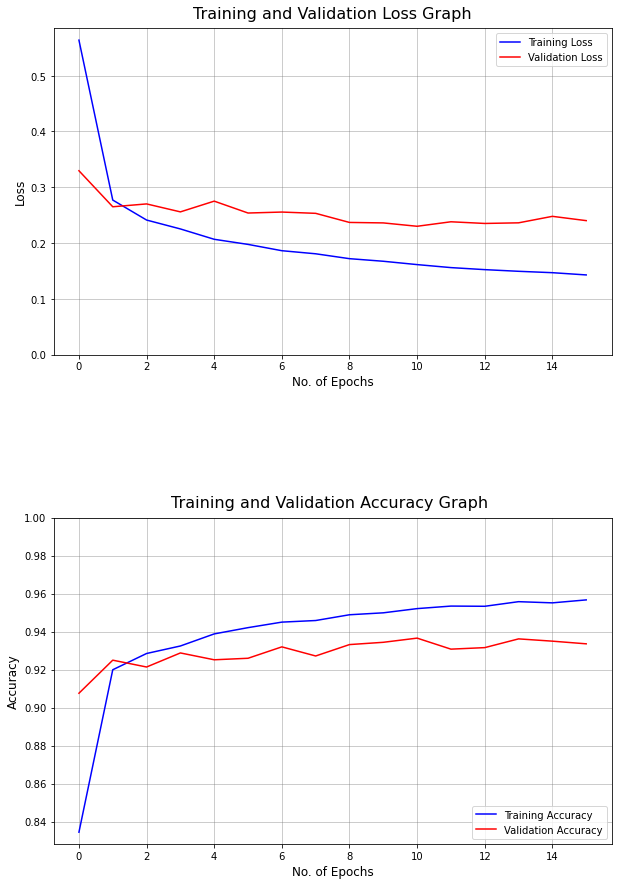

In [12]:
params = history["parameters"]
# params = history["best_params"]
train_acc = history["accuracy"]
train_loss = history["loss"]
val_acc = history["val_accuracy"]
val_loss = history["val_loss"]
epochs = len(val_acc)


visualize_training_results(train_acc, val_acc, train_loss, val_loss)    

In [13]:
print("\n Epochs\t | Train Acc\t | Train Loss\t | Val Acc\t | Val Loss")
print("--------------------------------------------------------------------")
for i in range(epochs):
    print(" %d\t | %f\t | %f\t | %f\t | %f"%(i+1,train_acc[i] ,train_loss[i],val_acc[i] ,val_loss[i] ))


 Epochs	 | Train Acc	 | Train Loss	 | Val Acc	 | Val Loss
--------------------------------------------------------------------
 1	 | 0.834479	 | 0.563779	 | 0.907600	 | 0.329603
 2	 | 0.919954	 | 0.277026	 | 0.925000	 | 0.265000
 3	 | 0.928508	 | 0.241205	 | 0.921400	 | 0.270108
 4	 | 0.932462	 | 0.225248	 | 0.928800	 | 0.255841
 5	 | 0.938815	 | 0.206686	 | 0.925200	 | 0.275091
 6	 | 0.942116	 | 0.197523	 | 0.926000	 | 0.253788
 7	 | 0.945018	 | 0.186222	 | 0.932000	 | 0.255516
 8	 | 0.945863	 | 0.180695	 | 0.927200	 | 0.253221
 9	 | 0.948892	 | 0.171935	 | 0.933200	 | 0.236903
 10	 | 0.949912	 | 0.167295	 | 0.934400	 | 0.236055
 11	 | 0.952129	 | 0.161300	 | 0.936600	 | 0.230027
 12	 | 0.953460	 | 0.155918	 | 0.930800	 | 0.238087
 13	 | 0.953356	 | 0.152274	 | 0.931600	 | 0.235089
 14	 | 0.955780	 | 0.149294	 | 0.936200	 | 0.236197
 15	 | 0.955158	 | 0.146802	 | 0.935000	 | 0.247844
 16	 | 0.956712	 | 0.142781	 | 0.933600	 | 0.240142


### Prediction

In [14]:
prediction_train = predict(train_x_norm, params, second_guess = True)
prediction_dev = predict(dev_x_norm,params, second_guess = True)
prediction_test = predict(test_x_norm, params, second_guess = True)

### Confusion Matrix

In [15]:
cm_train = confusion_matrix(train_y_split, prediction_train)
cm_dev = confusion_matrix(dev_y_split, prediction_dev)
cm_test = confusion_matrix(test_y_orig, prediction_test)

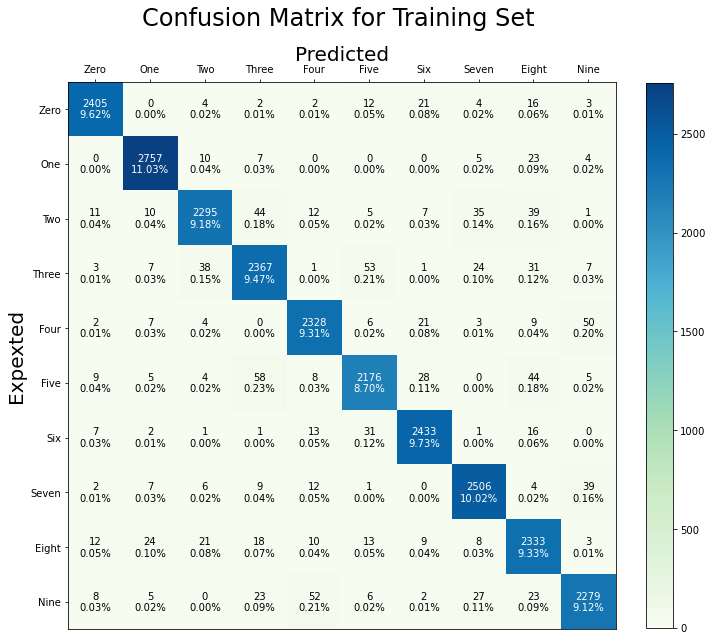

In [16]:
#plotting the confusion matrix   
plot_confusion_matrix(cm_train, dataset_type = "training")

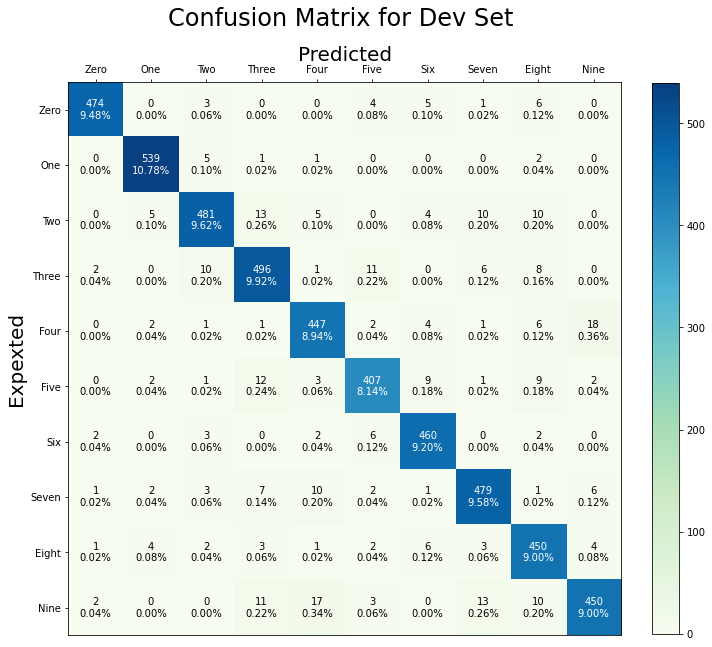

In [17]:
plot_confusion_matrix(cm_dev, dataset_type = "dev")

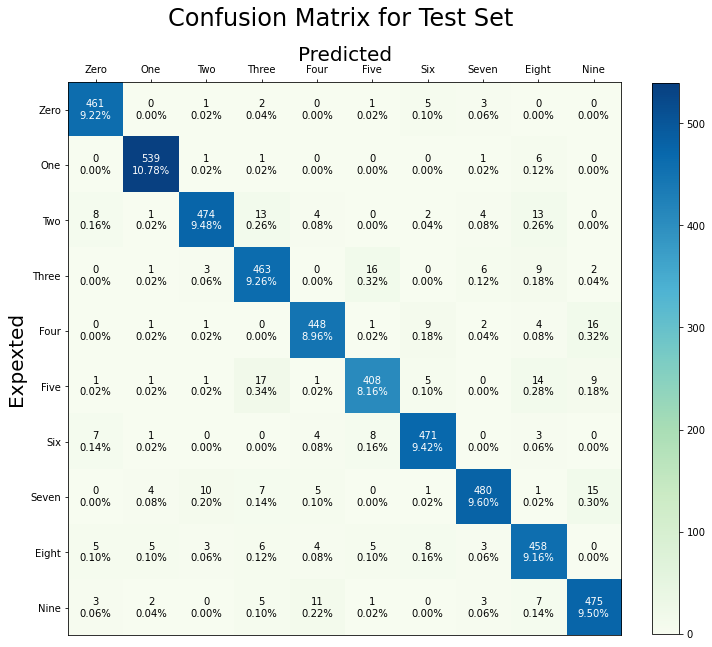

In [18]:
plot_confusion_matrix(cm_test, dataset_type = "test")

In [19]:
metrics, macro_metrics, acc = model_metrics(cm_train)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.97804 	|  0.97408 	|  0.97606 	|
| 1 		|  0.97627 	|  0.98254 	|  0.97940 	|
| 2 		|  0.96307 	|  0.93331 	|  0.94796 	|
| 3 		|  0.93594 	|  0.93483 	|  0.93539 	|
| 4 		|  0.95488 	|  0.95802 	|  0.95645 	|
| 5 		|  0.94485 	|  0.93111 	|  0.93793 	|
| 6 		|  0.96471 	|  0.97126 	|  0.96797 	|
| 7 		|  0.95905 	|  0.96906 	|  0.96403 	|
| 8 		|  0.91923 	|  0.95186 	|  0.93526 	|
| 9 		|  0.95316 	|  0.93979 	|  0.94643 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.95492 	|  0.95459 	|  0.95469 	|
+===============+===============+===============+===============+

 Accuracy 		  0.95516


In [20]:
metrics, macro_metrics, acc = model_metrics(cm_dev)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.98340 	|  0.96146 	|  0.97231 	|
| 1 		|  0.97292 	|  0.98358 	|  0.97822 	|
| 2 		|  0.94499 	|  0.91098 	|  0.92768 	|
| 3 		|  0.91176 	|  0.92884 	|  0.92022 	|
| 4 		|  0.91786 	|  0.92739 	|  0.92260 	|
| 5 		|  0.93135 	|  0.91256 	|  0.92186 	|
| 6 		|  0.94070 	|  0.96842 	|  0.95436 	|
| 7 		|  0.93191 	|  0.93555 	|  0.93372 	|
| 8 		|  0.89286 	|  0.94538 	|  0.91837 	|
| 9 		|  0.93750 	|  0.88933 	|  0.91278 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.93653 	|  0.93635 	|  0.93621 	|
+===============+===============+===============+===============+

 Accuracy 		  0.93660


In [21]:
metrics, macro_metrics, acc = model_metrics(cm_test)
metric_summary(metrics, macro_metrics, acc)

+===============+===============+===============+===============+
| Label 	| Precision 	| Recall 	| F1 Score 	|
+===============+===============+===============+===============+
| 0 		|  0.95052 	|  0.97463 	|  0.96242 	|
| 1 		|  0.97117 	|  0.98358 	|  0.97733 	|
| 2 		|  0.95951 	|  0.91329 	|  0.93583 	|
| 3 		|  0.90078 	|  0.92600 	|  0.91321 	|
| 4 		|  0.93920 	|  0.92946 	|  0.93431 	|
| 5 		|  0.92727 	|  0.89278 	|  0.90970 	|
| 6 		|  0.94012 	|  0.95344 	|  0.94673 	|
| 7 		|  0.95618 	|  0.91778 	|  0.93659 	|
| 8 		|  0.88932 	|  0.92153 	|  0.90514 	|
| 9 		|  0.91876 	|  0.93688 	|  0.92773 	|
+===============+===============+===============+===============+
| Macro Avg 	|  0.93528 	|  0.93494 	|  0.93490 	|
+===============+===============+===============+===============+

 Accuracy 		  0.93540


#### Visualizating  Prediction

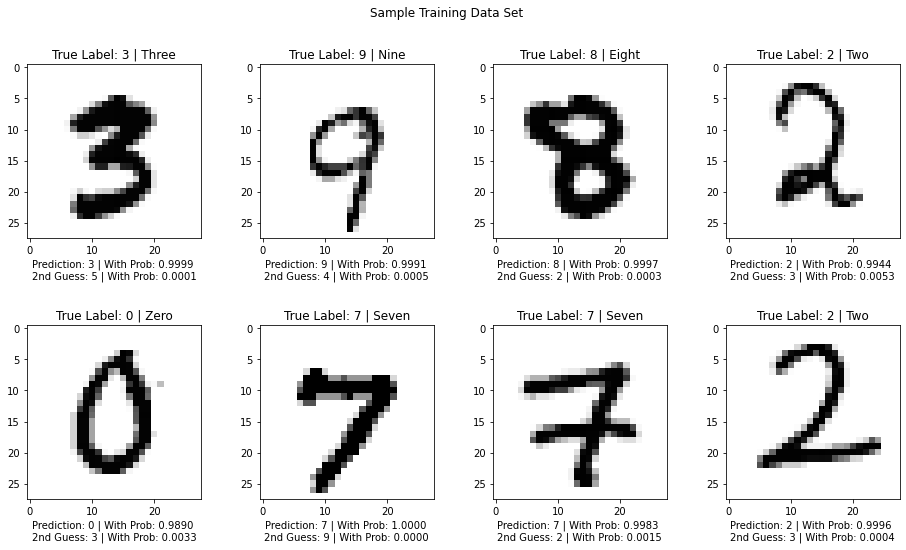

In [22]:
visualize_prediction(train_x_split, train_y_split.T, prediction_train, dataset_type = "training")

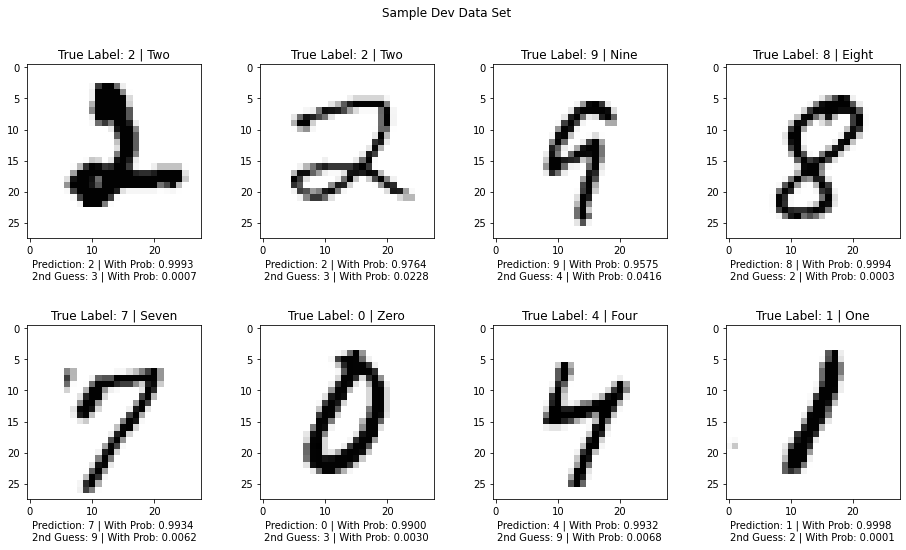

In [23]:
visualize_prediction(dev_x_split, dev_y_split.T, prediction_dev, dataset_type = "dev")

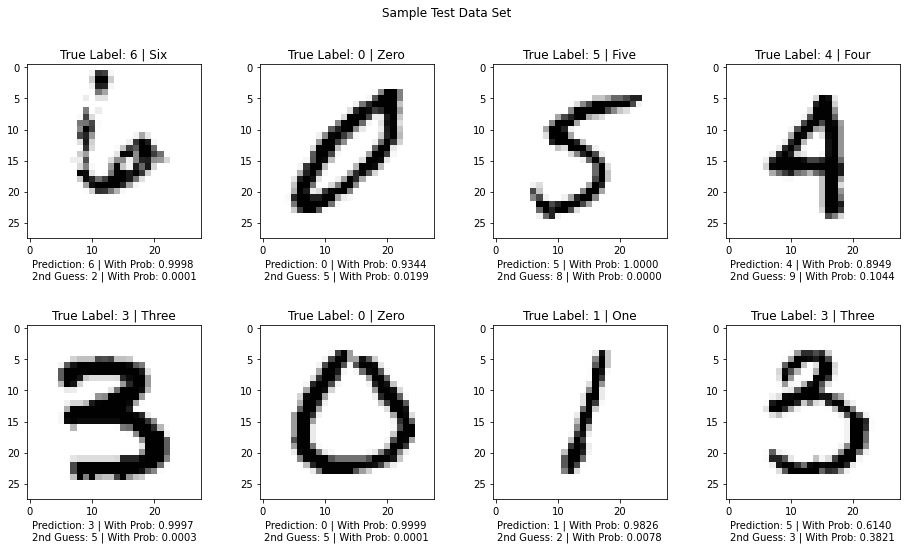

In [24]:
visualize_prediction(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

#### Visualizing Mislabelled Images in all datasets

Total Mislabelled Images: 1121


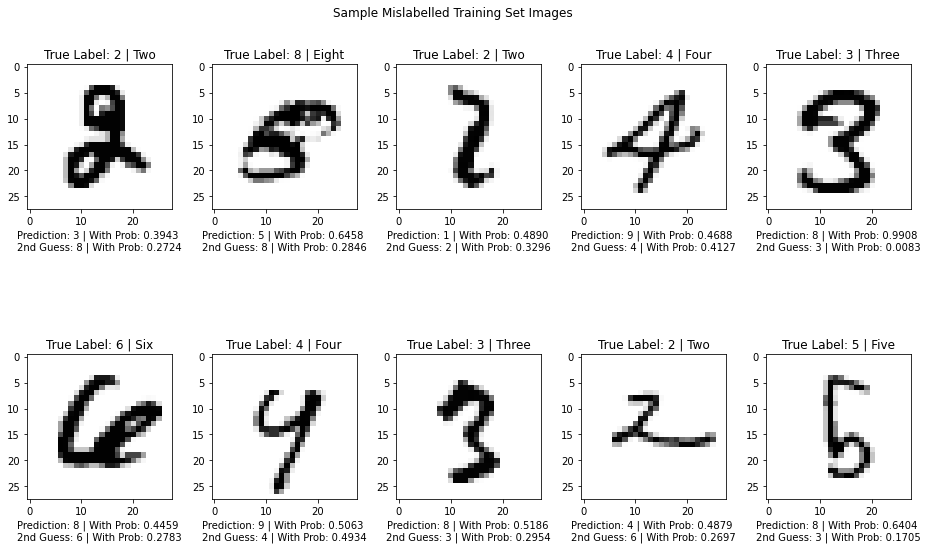

In [25]:
visualize_mislabelled_images(train_x_split, train_y_split.T,prediction_train,dataset_type = "training")

Total Mislabelled Images: 317


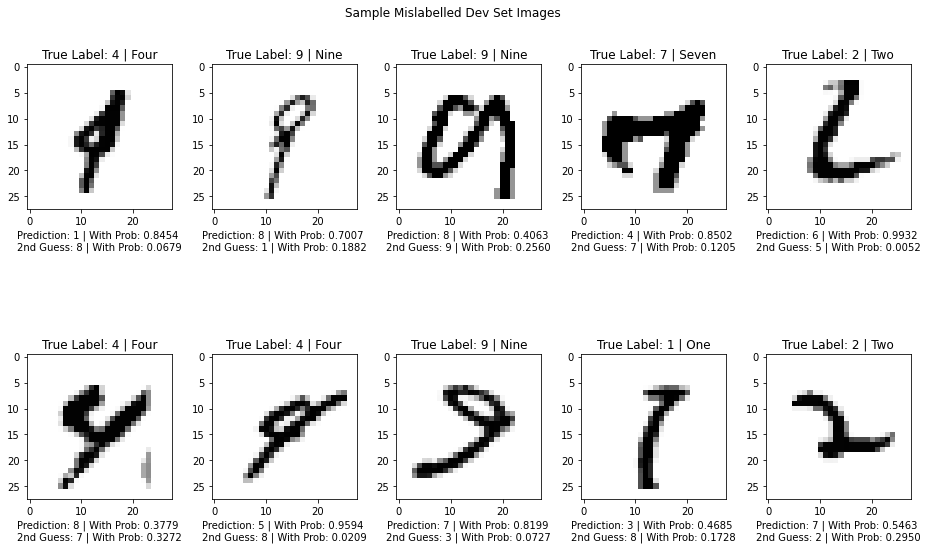

In [26]:
visualize_mislabelled_images(dev_x_split, dev_y_split.T, prediction_dev,dataset_type = "dev")

Total Mislabelled Images: 323


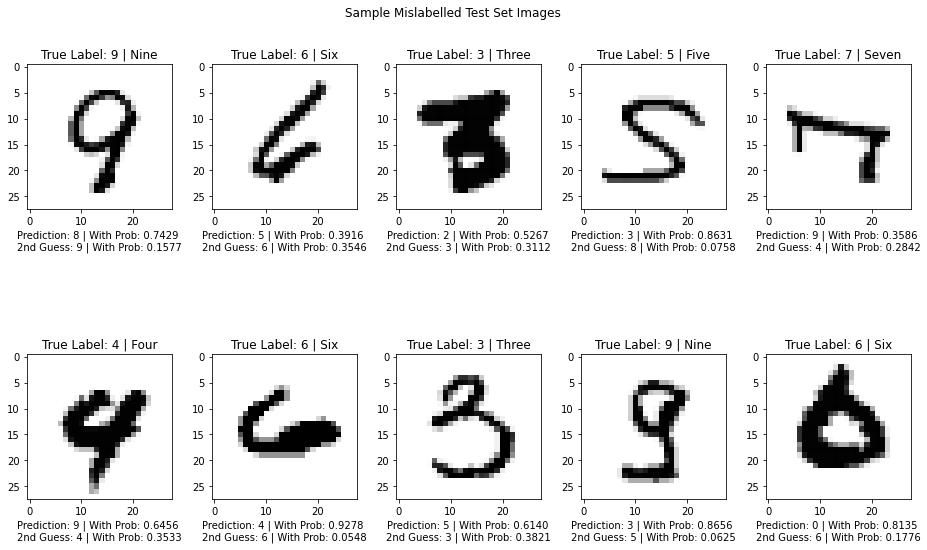

In [27]:
visualize_mislabelled_images(test_x_orig, test_y_orig.T, prediction_test,dataset_type = "test")

### Predicting Real Time images

In [28]:
from PIL import Image

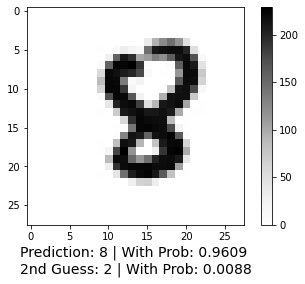

In [29]:
image_name = "8_1.jpg" 

fname = "Sample Images/" + image_name

image_data = np.asarray(Image.open(fname).convert('L').resize((28,28)))
if image_data[1,1] > 250: #if background is white, reversing the fore and background color to match training images
            image_data = 255 - image_data
def predict_real_time(image_data, second_guess = True):
    image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
    image_norm =(image_flattened/255.)

    prediction = predict(image_norm, params, second_guess = second_guess)
    
    return prediction
    
prediction = predict_real_time(image_data, second_guess = True)

first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

# plt.title("True Label: "+ str(label.squeeze()))
plt.xlabel("Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob), fontsize = 14)
plt.imshow(image_data, interpolation ='nearest',cmap='Greys')
plt.colorbar()


## Saving and Loading model

In [30]:
from datetime import date

d = date.today()

path = "Saved Models/"
fname = str(d) + "_Augmented_best_model_test_acc_98-84"

print(fname)

model = {"Parameters": params,
         "Activations": ["relu","relu","softmax"],
## Save the following info if needed
         "Hyper Parameters": hyperParams,
         "initialization":"he",
         "regularizer":"dropout",
         "optimizer":"adam"
        }
save_model(file_name = path+fname, model = model)

2021-01-19_Augmented_best_model_test_acc_98-84


In [ ]:
# loading model
path = "Saved Models/"

model = load_model(file_name =path+ "2020-07-21_Augmented_best_model_test_acc_98-84")

loaded_params = model["Parameters"]

In [ ]:
L = len(loaded_params) // 2
print("Total Layers %d: "%L)
for l in range(L):
    print(loaded_params["W" + str(l+1)].shape[0])


## To Do

- [x] Optimize and refactor the code
- [x] Prepare the doc String
- [x] add verbose: Integer. 0, 1, 2 or 3. Verbosity mode.
- [ ] Batch norm
- [ ] Maxout
- [ ] Drop Connect
- [x] Data Augmentation if possible

In [ ]:
!jupyter-nbconvert --to html 'Project Modules Evaluation.ipynb' --output Experiments/experiment-8/early_stopping_learning_rate_decay5.html